Episode: 0, Step: 400, Counter: 0, Attached_counter: 0, Total reward: -801.363525390625, final state: tensor([-0.0123, -0.4058,  0.2784,  0.1184]), 
Episode: 100, Step: 400, Counter: 3, Attached_counter: 0, Total reward: -769.6500244140625, final state: tensor([0.0753, 0.2937, 0.0063, 0.3917]), 
Episode: 200, Step: 400, Counter: 11, Attached_counter: 0, Total reward: -1003.4873046875, final state: tensor([ 1.7720, -1.9257,  0.0915,  0.1281]), 
SUCCESSO Episode: 268, Step: 240, Counter: 20, Attached_counter: 0, Total reward: -386.8446960449219, final state: tensor([ 0.5840, -0.0733,  0.5853, -0.0867])
Episode: 300, Step: 400, Counter: 24, Attached_counter: 0, Total reward: -776.4625244140625, final state: tensor([-0.5823, -0.5163, -0.5735, -0.2117]), 
SUCCESSO Episode: 366, Step: 12, Counter: 40, Attached_counter: 0, Total reward: 33.37601089477539, final state: tensor([ 0.5647, -0.1040,  0.5726, -0.1117])
Episode: 400, Step: 400, Counter: 59, Attached_counter: 0, Total reward: -794.575

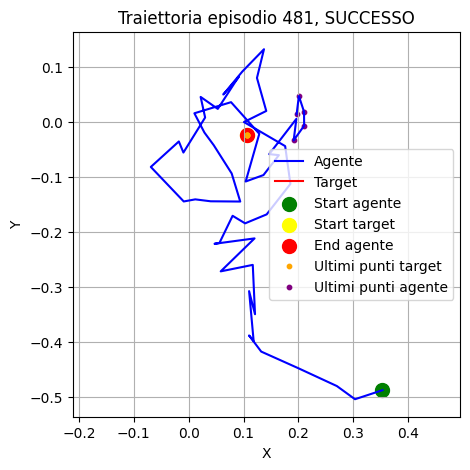

Episode: 500, Step: 400, Counter: 107, Attached_counter: 0, Total reward: -770.0706176757812, final state: tensor([ 0.3639, -0.0770,  0.4875, -0.3005]), 


KeyboardInterrupt: 

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from environment import TrackingEnv

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_MEMORY = 4000
NUM_NEURONS = 256
LR_CRITIC = 0.0001  #0.0005
LR_ACTOR = 0.0005   #0.001
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
K_EPOCH = 10
EARLY_STOPPING_EPISODES = 30
ENTROPY_COEFF = 0.01

def compute_advantages(rewards, values, dones, gamma=GAMMA, lam=LAMBDA):
    advantages = []
    gae = 0
    values = torch.cat([values, torch.tensor([0], dtype=values.dtype, device=values.device)])  # Append a 0 for the last state
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return torch.tensor(advantages, dtype=torch.float)

def compute_returns(rewards, dones, gamma=0.99):
    returns = []
    G = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        G = reward + gamma * G * (1 - done)  # Reset if episode ended
        returns.insert(0, G)
    return returns

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()

        self.noise_std = 0.02
        
        self.fc1 = nn.Linear(state_dim, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        
        # Output per la media (mu)
        self.mu_layer = nn.Linear(NUM_NEURONS, action_dim)
        
        # Output per la deviazione standard (log_sigma)
        self.log_sigma_layer = nn.Linear(NUM_NEURONS, action_dim)

    def add_noise_to_target(self, state):
        state = state.clone()
        if state.dim() == 1:
            state[2:4] += torch.normal(0.0, self.noise_std, size=(2,), device=state.device)
        else:
            state[:, 2:4] += torch.normal(0.0, self.noise_std, size=state[:, 2:4].shape, device=state.device)
        return state


    def forward(self, state):#, exploration_term):

        #state = self.add_noise_to_target(state)

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # Media delle azioni
        mu = self.mu_layer(x)
        mu = 5.0*torch.tanh(mu)    # azioni in [-5, 5]
        
        # Deviazione standard (softplus per garantire positività)
        log_sigma = self.log_sigma_layer(x)
        sigma = F.softplus(log_sigma) + 1e-5 # 1e-5 per evitare log(0)
        #sigma = F.softplus(log_sigma) + exploration_term + 1e-5 # 1e-5 per evitare log(0)

        return mu, sigma

class ValueNet(nn.Module):
    def __init__(self, num_inputs):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class PPOAgent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PPOAgent, self).__init__()
        self.actor = PolicyNet(num_inputs, num_actions)
        self.critic = ValueNet(num_inputs)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.buffer = []
    
    def get_action(self, state):
        mu, sigma = self.actor.forward(state)#, exploration_term)
        dist = torch.distributions.Normal(mu, sigma)
        action = dist.rsample()  # Usa reparametrization trick per il backprop
        log_prob = dist.log_prob(action).sum(dim=-1)  # Somma log-prob per dimensione azione
        return action.detach(), log_prob

    def store_transition(self, transition):
        self.buffer.append(transition)



    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):

    #     pos = state[:2]
    #     target = state[2:4]
    #     next_pos = next_state[:2]
    #     #next_pos = torch.tensor(next_pos, dtype=torch.float32)

        # to_target = F.normalize(target - pos, dim=0)          # direzione ideale
        # action_dir = F.normalize(action, dim=0)               # direzione dell’azione
        # direction_reward = torch.dot(action_dir, to_target)   # massimo = 1, minimo = -1

        # # Distanze
        # dist_before = torch.norm(pos - target)
        # dist_after = torch.norm(next_pos - target)
        # progress = dist_before - dist_after
        
        # step_penalty = 0.01 * step # 0.01

        # #Se raggiunge il target
        # if dist_after < tolerance:
        #    reward = 500 - 5 * step #if step > 100 else 500
        #    #reward = 500
        # else:
        #    #reward = "quanto mi avvicino" + "quanto vado nella direzione giusta"
        #    reward = 2 * progress + 5 * direction_reward  # pesi da tarare 2 5

        # if rimbalzato:
        #    reward += -5

        # return reward - step_penalty
    

    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato, attached_counter):
    #     pos = state[:2]
    #     target = state[2:4]              # target(t)
    #     next_pos = next_state[:2]        # agent(t+1)

    #     to_target = F.normalize(target - pos, dim=0)
    #     action_dir = F.normalize(action, dim=0)
    #     direction_reward = torch.dot(action_dir, to_target)

    #     dist_before = torch.norm(pos - target)
    #     dist_after = torch.norm(next_pos - target)  # sempre verso target(t)
    #     progress = dist_before - dist_after

    #     step_penalty = 0.018 * step
    #     reward = 0

    #     # Calcola la distanza rispetto al target precedente
    #     dist_to_target = torch.norm(next_pos - target)

    #     if dist_to_target < tolerance:
    #         # Raggiunto o mantenuto nella soglia rispetto al target precedente
    #         reward += 2                         # base reward
    #         reward += 0.5 * attached_counter    # più tempo resta vicino → più reward
    #     else:
    #         # Fase di inseguimento
    #         reward += 2 * progress + 4 * direction_reward

    #         if progress < 0:
    #             reward += 3 * progress  # penalizzazione per allontanamento

    #     if rimbalzato:
    #         reward -= 5

    #     return reward - step_penalty

    def reward_function(self, state, action, next_state, step, tolerance, rimbalzato, attached_counter):
        #reward = - torch.norm(next_state[:2] - state[2:4]) -1
        pos = state[:2]
        target = state[2:4]              # target(t)
        next_pos = next_state[:2]        # agent(t+1)

        to_target = F.normalize(target - pos, dim=0)
        action_dir = F.normalize(action, dim=0)
        direction_reward = torch.dot(action_dir, to_target)
        direction_penalty = 1.0 - direction_reward

        dist_before = torch.norm(pos - target)
        dist_after = torch.norm(next_pos - target)  # sempre verso target(t)
        progress = dist_before - dist_after

        reward = - direction_penalty #+ progress

        if torch.norm(next_state[:2] - state[2:4]) < tolerance:
            reward += 50
        
        if rimbalzato:
            reward -= 5

        return reward - 1
        
    
    def update(self):
        torch.autograd.set_detect_anomaly(True)
        states, actions, rewards, dones, old_log_probs = zip(*self.buffer)
        old_log_probs = torch.stack(old_log_probs)
        states = torch.stack(states)
        actions = torch.stack(actions).float()
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        values = self.critic(states).squeeze()
        advantages = compute_advantages(rewards, values.detach(), dones)
        returns = compute_returns(rewards, dones)  # Compute Monte Carlo returns
        returns = torch.tensor(returns, dtype=torch.float32)
        
        for _ in range(K_EPOCH):
            means, stds = self.actor(states)
            dist = torch.distributions.Normal(means, stds)
            entropy = dist.entropy().sum(dim=-1).mean()  # media sull’intero batch
            new_log_probs = dist.log_prob(actions).sum(dim=-1)
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * advantages
            policy_loss = -torch.min(surr1, surr2).mean() - ENTROPY_COEFF * entropy
            values_pred =self.critic(states).squeeze()
            value_loss = F.mse_loss(values_pred, returns)

            total_loss = policy_loss + value_loss

            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            #policy_loss.backward()
            #value_loss.backward()
            total_loss.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
        
        self.buffer.clear()

def train_ppo(env=None, num_episodes=6001):
    if env is None:
        env = TrackingEnv()
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]
    agent = PPOAgent(num_inputs, num_actions)
    reward_history = []
    success_history = []
    counter = 0
    tolerance = 0.02 #0.05
    
    for episode in range(num_episodes):
        #target = np.random.uniform(-0.05, 0.05, size=(2,))    # -0.5, 0.5 non convergeva in 4000 episodi
        #target = torch.tensor(target, dtype=torch.float32)
        state, _ = env.reset()#(target=target)
        done = False
        total_reward = 0
        state = torch.tensor(state, dtype=torch.float32)
        trajectory = []
        target_trajectory = []
        step = 0
        attached_counter = 0
        
        while not done:
            step += 1
            trajectory.append(state[:2].detach().numpy())
            target_trajectory.append(state[2:4].detach().numpy())
            action, log_prob = agent.get_action(state)
            
            # if step == 50:
            #     print(action)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4])<tolerance or truncated:
               done = True
            # if torch.norm(next_state[:2] - target_trajectory[-1])<tolerance:
            #     attached_counter += 1
            
            reward = agent.reward_function(state, action, next_state, step, tolerance, rimbalzato, attached_counter)

            #if truncated or (torch.norm(next_state[:2]-target_trajectory[-1])>tolerance and attached_counter > 0):
            #    done = True

            #done = done or truncated

            agent.store_transition((state, action, reward, done, log_prob))
            state = next_state
            total_reward += reward
        
        if torch.norm(next_state[:2] - next_state[2:4])<tolerance:
        #if attached_counter > 10:
            counter += 1
            success_history.append(1)
            # PLOTTING TRAIETTORIA A SUCCESSO
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            if counter % 20 == 0:
                print(f"SUCCESSO Episode: {episode}, Step: {step}, Counter: {counter}, Attached_counter: {attached_counter}, Total reward: {total_reward}, final state: {state}")
            if counter % 100 == 0:
                
                plt.figure(figsize=(5, 5))
                plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agente", color='blue')
                plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], label="Target", color='red')
                plt.scatter(*trajectory[0], color='green', label='Start agente', s=100)
                plt.scatter(*target_trajectory[0], color='yellow', label='Start target', s=100)
                plt.scatter(*target_trajectory[-1], color='red', label='End agente', s=100)
                # Stampa gli ultimi 5 punti della traiettoria del target
                plt.scatter(target_trajectory[-5:, 0], target_trajectory[-5:, 1], color='orange', label='Ultimi punti target', s=10)
                # Stampa l'ultimo punto della traiettoria dell'agente
                plt.scatter(trajectory[-5:, 0], trajectory[-5:, 1], color='purple', label='Ultimi punti agente', s=10)
                plt.title(f"Traiettoria episodio {episode}, SUCCESSO")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend()
                plt.grid()
                plt.axis('equal')
                plt.show()

        else:
            success_history.append(0)

        reward_history.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Attached_counter: {attached_counter}, Total reward: {total_reward}, final state: {state}, ")

        #if attached_counter > 10:
            # print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Attached_counter: {attached_counter}, Total reward: {total_reward}, final state: {state}, ")

        # if episode % 100 == 0:
        #     trajectory = np.array(trajectory)
        #     #target = next_state[2:4].detach().numpy()  # x_target, y_target
        #     target_trajectory = np.array(target_trajectory)

        #     plt.figure(figsize=(5, 5))
        #     plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agente", color='blue')
        #     plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], linestyle='-', label="Target", color='red')
        #     plt.scatter(*trajectory[0], color='green', label='Start agente', s=100)
        #     plt.scatter(*target_trajectory[0], color='orange', label='Start target', s=100)
        #     # Stampa gli ultimi 5 punti della traiettoria del target
        #     plt.scatter(target_trajectory[-5:, 0], target_trajectory[-5:, 1], color='orange', label='Ultimi punti target', s=10)
        #         # Stampa l'ultimo punto della traiettoria dell'agente
        #     plt.scatter(trajectory[-5:, 0], trajectory[-5:, 1], color='purple', label='Ultimi punti agente', s=10)
        #     plt.title(f"Traiettoria episodio {episode}")
        #     plt.xlabel("X")
        #     plt.ylabel("Y")
        #     plt.legend()
        #     plt.grid()
        #     plt.axis('equal')
        #     plt.show()

        
        #if len(reward_history)>EARLY_STOPPING_EPISODES and all(s == 1 for s in success_history[-EARLY_STOPPING_EPISODES:]):
        #    break
        
        #if len(reward_history) > EARLY_STOPPING_EPISODES and np.mean(reward_history[-EARLY_STOPPING_EPISODES:]) > -30:
        #    print(f"Early stopping at episode {episode}")
        #    break

        if len(agent.buffer) >= MAX_MEMORY:
            agent.update()
    
    env.close()

    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()


    return agent

if __name__ == "__main__":
    trained_agent = train_ppo()


In [3]:
# Per salvare solo i pesi
torch.save(trained_agent.actor.state_dict(), "ppo_policy.pt")
torch.save(trained_agent.critic.state_dict(), "ppo_critic.pt")


In [ ]:
def test_agent_with_random_targets(agent, env=None, num_episodes=100, target_sampler=None, tolerance=0.02):
    if env is None:
        env = TrackingEnv()

    agent.eval()

    final_distances = []
    success_counter = 0

    for ep in range(num_episodes):
        # # Genera un target casuale (es. all’interno di uno spazio 2D limitato)
        # if target_sampler:
        #     target = target_sampler()
        #     target = torch.tensor(target, dtype=torch.float32)
        # else:
        #     target = np.random.uniform(low=-0.5, high=0.5, size=(2,))  # Default sampler
        #     target = torch.tensor(target, dtype=torch.float32)

        state, _ = env.reset()#target=target)
        state = torch.tensor(state, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []

        while not done:
            trajectory.append(state.detach().numpy())
            action, _ = agent.get_action(state)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True
            state = next_state
            step += 1

        trajectory = np.array(trajectory)
        final_dist = np.linalg.norm(state[:2] - state[2:4])
        final_distances.append(final_dist)
        print(f"[Episode {ep}] Steps: {step}, Final distance: {final_dist:.4f}")

        success = False

        if final_dist < tolerance:
            success = True
            success_counter += 1


        #if success and ep % 10 == 0:
        plt.figure(figsize=(5, 5))
        plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
        plt.scatter(*state[2:4], color='red', label='Target', s=100)
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
        plt.title(f"Test con target casuale – episodio {ep}, successo: {success}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.grid()
        plt.axis('equal')
        plt.show()

    env.close()

    print(f"Media delle distanze finali: {np.mean(final_distances):.4f}, numero di successi: {success_counter}")

def target_sampler():
    # Genera target in un quadrato [-1, 1] x [-1, 1]
    return np.random.uniform(low=-0.5, high=0.5, size=(2,))


test_agent_with_random_targets(trained_agent)#, target_sampler=target_sampler)

Episode 0 | Final distance: 0.0240 | Success: False


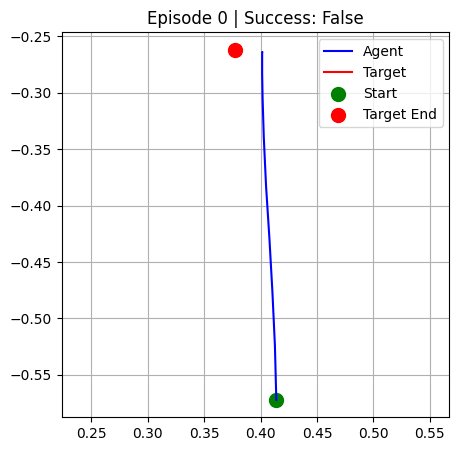

Episode 1 | Final distance: 0.0168 | Success: True
Episode 2 | Final distance: 0.0160 | Success: True
Episode 3 | Final distance: 0.0295 | Success: False
Episode 4 | Final distance: 0.0079 | Success: True
Episode 5 | Final distance: 0.0189 | Success: True
Episode 6 | Final distance: 0.0191 | Success: True
Episode 7 | Final distance: 0.0109 | Success: True
Episode 8 | Final distance: 0.0156 | Success: True
Episode 9 | Final distance: 0.0163 | Success: True
Episode 10 | Final distance: 0.0117 | Success: True
Episode 11 | Final distance: 0.0148 | Success: True
Episode 12 | Final distance: 0.0174 | Success: True
Episode 13 | Final distance: 0.0081 | Success: True
Episode 14 | Final distance: 0.0169 | Success: True
Episode 15 | Final distance: 0.0160 | Success: True
Episode 16 | Final distance: 0.0133 | Success: True
Episode 17 | Final distance: 0.0193 | Success: True
Episode 18 | Final distance: 0.0031 | Success: True
Episode 19 | Final distance: 0.0156 | Success: True
Episode 20 | Final d

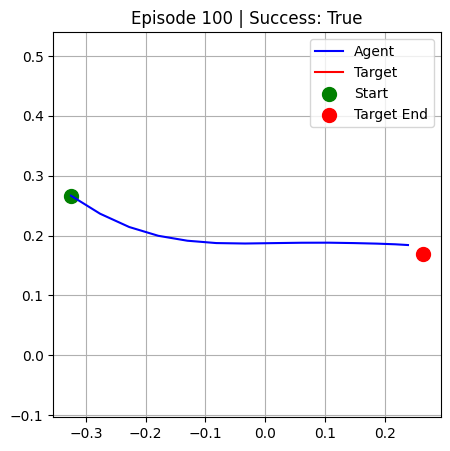

Episode 101 | Final distance: 0.0163 | Success: True
Episode 102 | Final distance: 0.0061 | Success: True
Episode 103 | Final distance: 0.0114 | Success: True
Episode 104 | Final distance: 0.0167 | Success: True
Episode 105 | Final distance: 0.0168 | Success: True
Episode 106 | Final distance: 0.0132 | Success: True
Episode 107 | Final distance: 0.0187 | Success: True
Episode 108 | Final distance: 0.0074 | Success: True
Episode 109 | Final distance: 0.0165 | Success: True
Episode 110 | Final distance: 0.0191 | Success: True
Episode 111 | Final distance: 0.0190 | Success: True
Episode 112 | Final distance: 0.0114 | Success: True
Episode 113 | Final distance: 0.0169 | Success: True
Episode 114 | Final distance: 0.0183 | Success: True
Episode 115 | Final distance: 0.0199 | Success: True
Episode 116 | Final distance: 0.0155 | Success: True
Episode 117 | Final distance: 0.0185 | Success: True
Episode 118 | Final distance: 0.0138 | Success: True
Episode 119 | Final distance: 0.0146 | Success

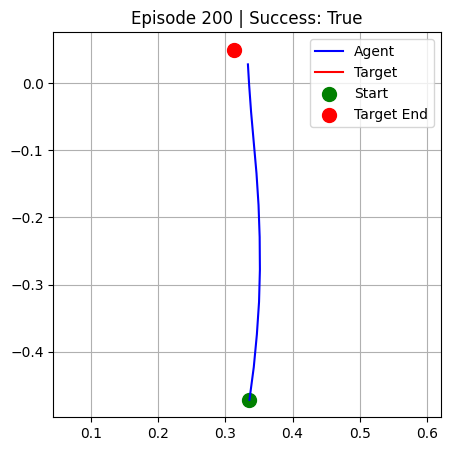

Episode 201 | Final distance: 0.0182 | Success: True
Episode 202 | Final distance: 0.0147 | Success: True
Episode 203 | Final distance: 0.0131 | Success: True
Episode 204 | Final distance: 0.0143 | Success: True
Episode 205 | Final distance: 0.0190 | Success: True
Episode 206 | Final distance: 0.0196 | Success: True
Episode 207 | Final distance: 0.0189 | Success: True
Episode 208 | Final distance: 0.0189 | Success: True
Episode 209 | Final distance: 0.0152 | Success: True
Episode 210 | Final distance: 0.0139 | Success: True
Episode 211 | Final distance: 0.0112 | Success: True
Episode 212 | Final distance: 0.0073 | Success: True
Episode 213 | Final distance: 0.0301 | Success: False
Episode 214 | Final distance: 0.0133 | Success: True
Episode 215 | Final distance: 0.0315 | Success: False
Episode 216 | Final distance: 0.0192 | Success: True
Episode 217 | Final distance: 0.0140 | Success: True
Episode 218 | Final distance: 0.0227 | Success: False
Episode 219 | Final distance: 0.0138 | Succ

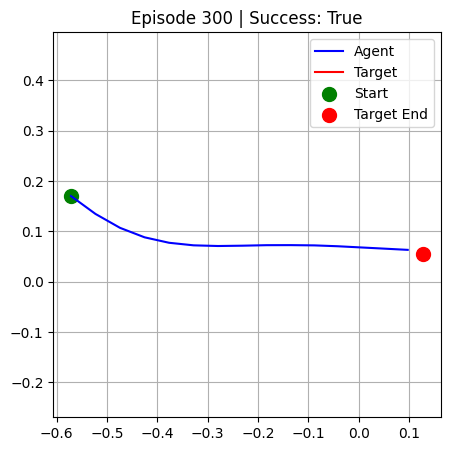

Episode 301 | Final distance: 0.0128 | Success: True
Episode 302 | Final distance: 0.0178 | Success: True
Episode 303 | Final distance: 0.0162 | Success: True
Episode 304 | Final distance: 0.0137 | Success: True
Episode 305 | Final distance: 0.0164 | Success: True
Episode 306 | Final distance: 0.0144 | Success: True
Episode 307 | Final distance: 0.0129 | Success: True
Episode 308 | Final distance: 0.0177 | Success: True
Episode 309 | Final distance: 0.0132 | Success: True
Episode 310 | Final distance: 0.0190 | Success: True
Episode 311 | Final distance: 0.0084 | Success: True
Episode 312 | Final distance: 0.0149 | Success: True
Episode 313 | Final distance: 0.0108 | Success: True
Episode 314 | Final distance: 0.0325 | Success: False
Episode 315 | Final distance: 0.0157 | Success: True
Episode 316 | Final distance: 0.0165 | Success: True
Episode 317 | Final distance: 0.0175 | Success: True
Episode 318 | Final distance: 0.0197 | Success: True
Episode 319 | Final distance: 0.0181 | Succes

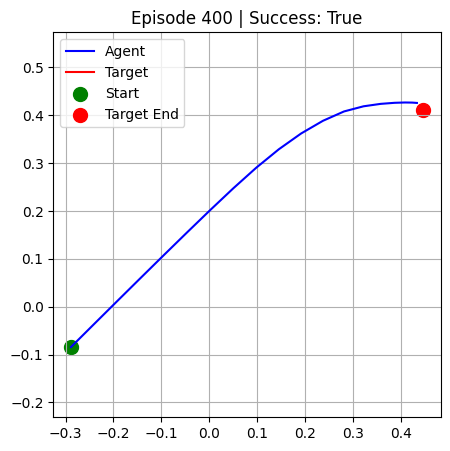

Episode 401 | Final distance: 0.0101 | Success: True
Episode 402 | Final distance: 0.0200 | Success: True
Episode 403 | Final distance: 0.0194 | Success: True
Episode 404 | Final distance: 0.0130 | Success: True
Episode 405 | Final distance: 0.0190 | Success: True
Episode 406 | Final distance: 0.0151 | Success: True
Episode 407 | Final distance: 0.0153 | Success: True
Episode 408 | Final distance: 0.0087 | Success: True
Episode 409 | Final distance: 0.0199 | Success: True
Episode 410 | Final distance: 0.0118 | Success: True
Episode 411 | Final distance: 0.0240 | Success: False
Episode 412 | Final distance: 0.0174 | Success: True
Episode 413 | Final distance: 0.0119 | Success: True
Episode 414 | Final distance: 0.0170 | Success: True
Episode 415 | Final distance: 0.0159 | Success: True
Episode 416 | Final distance: 0.0144 | Success: True
Episode 417 | Final distance: 0.0173 | Success: True
Episode 418 | Final distance: 0.0118 | Success: True
Episode 419 | Final distance: 0.0190 | Succes

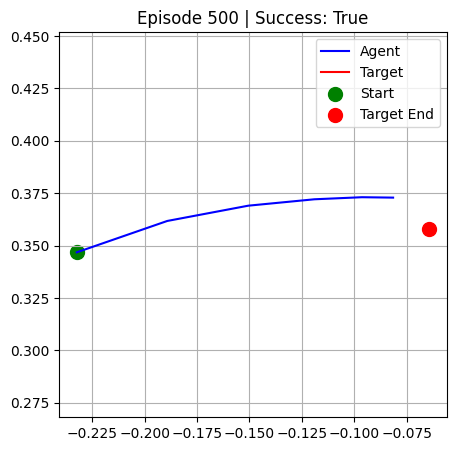

Episode 501 | Final distance: 0.0284 | Success: False
Episode 502 | Final distance: 0.0106 | Success: True
Episode 503 | Final distance: 0.0105 | Success: True
Episode 504 | Final distance: 0.0082 | Success: True
Episode 505 | Final distance: 0.0098 | Success: True
Episode 506 | Final distance: 0.0178 | Success: True
Episode 507 | Final distance: 0.0147 | Success: True
Episode 508 | Final distance: 0.0181 | Success: True
Episode 509 | Final distance: 0.0180 | Success: True
Episode 510 | Final distance: 0.0193 | Success: True
Episode 511 | Final distance: 0.0098 | Success: True
Episode 512 | Final distance: 0.0191 | Success: True
Episode 513 | Final distance: 0.0129 | Success: True
Episode 514 | Final distance: 0.0296 | Success: False
Episode 515 | Final distance: 0.0099 | Success: True
Episode 516 | Final distance: 0.0189 | Success: True
Episode 517 | Final distance: 0.0177 | Success: True
Episode 518 | Final distance: 0.0160 | Success: True
Episode 519 | Final distance: 0.0165 | Succe

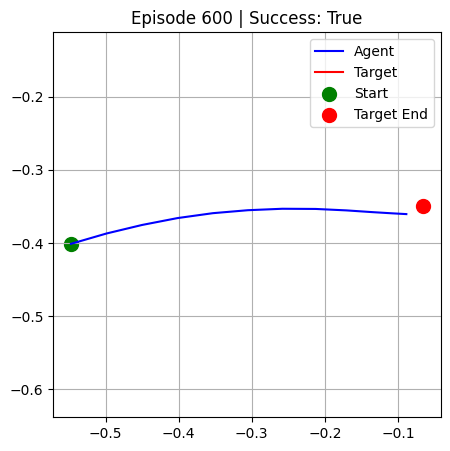

Episode 601 | Final distance: 0.0155 | Success: True
Episode 602 | Final distance: 0.0058 | Success: True
Episode 603 | Final distance: 0.0145 | Success: True
Episode 604 | Final distance: 0.0145 | Success: True
Episode 605 | Final distance: 0.0049 | Success: True
Episode 606 | Final distance: 0.0190 | Success: True
Episode 607 | Final distance: 0.0199 | Success: True
Episode 608 | Final distance: 0.0119 | Success: True
Episode 609 | Final distance: 0.0175 | Success: True
Episode 610 | Final distance: 0.0187 | Success: True
Episode 611 | Final distance: 0.0183 | Success: True
Episode 612 | Final distance: 0.0174 | Success: True
Episode 613 | Final distance: 0.0150 | Success: True
Episode 614 | Final distance: 0.0195 | Success: True
Episode 615 | Final distance: 0.0185 | Success: True
Episode 616 | Final distance: 0.0167 | Success: True
Episode 617 | Final distance: 0.0077 | Success: True
Episode 618 | Final distance: 0.0132 | Success: True
Episode 619 | Final distance: 0.0146 | Success

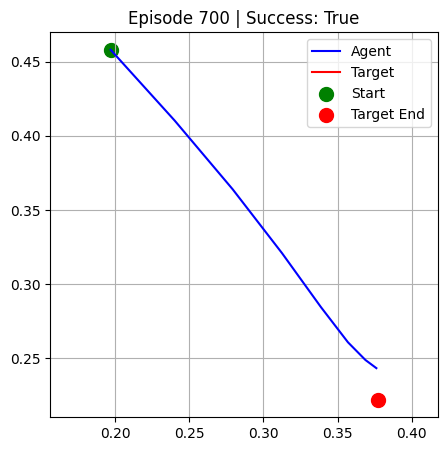

Episode 701 | Final distance: 0.0183 | Success: True
Episode 702 | Final distance: 0.0166 | Success: True
Episode 703 | Final distance: 0.0160 | Success: True
Episode 704 | Final distance: 0.0180 | Success: True
Episode 705 | Final distance: 0.0182 | Success: True
Episode 706 | Final distance: 0.0181 | Success: True
Episode 707 | Final distance: 0.0188 | Success: True
Episode 708 | Final distance: 0.0128 | Success: True
Episode 709 | Final distance: 0.0115 | Success: True
Episode 710 | Final distance: 0.0084 | Success: True
Episode 711 | Final distance: 0.0124 | Success: True
Episode 712 | Final distance: 0.0126 | Success: True
Episode 713 | Final distance: 0.0150 | Success: True
Episode 714 | Final distance: 0.0188 | Success: True
Episode 715 | Final distance: 0.0150 | Success: True
Episode 716 | Final distance: 0.0069 | Success: True
Episode 717 | Final distance: 0.0144 | Success: True
Episode 718 | Final distance: 0.0163 | Success: True
Episode 719 | Final distance: 0.0193 | Success

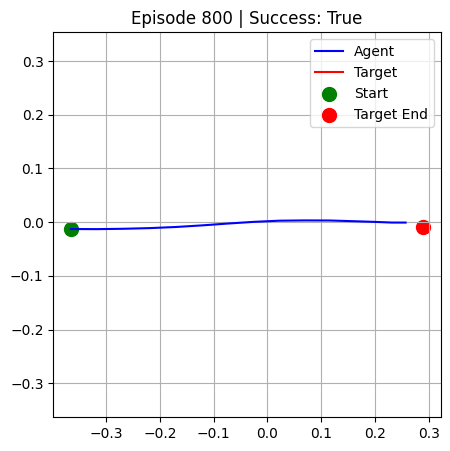

Episode 801 | Final distance: 0.0158 | Success: True
Episode 802 | Final distance: 0.0104 | Success: True
Episode 803 | Final distance: 0.0051 | Success: True
Episode 804 | Final distance: 0.0159 | Success: True
Episode 805 | Final distance: 0.0184 | Success: True
Episode 806 | Final distance: 0.0105 | Success: True
Episode 807 | Final distance: 0.0192 | Success: True
Episode 808 | Final distance: 0.0120 | Success: True
Episode 809 | Final distance: 0.0172 | Success: True
Episode 810 | Final distance: 0.0210 | Success: False
Episode 811 | Final distance: 0.0113 | Success: True
Episode 812 | Final distance: 0.0179 | Success: True
Episode 813 | Final distance: 0.0198 | Success: True
Episode 814 | Final distance: 0.0144 | Success: True
Episode 815 | Final distance: 0.0190 | Success: True
Episode 816 | Final distance: 0.0115 | Success: True
Episode 817 | Final distance: 0.0171 | Success: True
Episode 818 | Final distance: 0.0190 | Success: True
Episode 819 | Final distance: 0.0171 | Succes

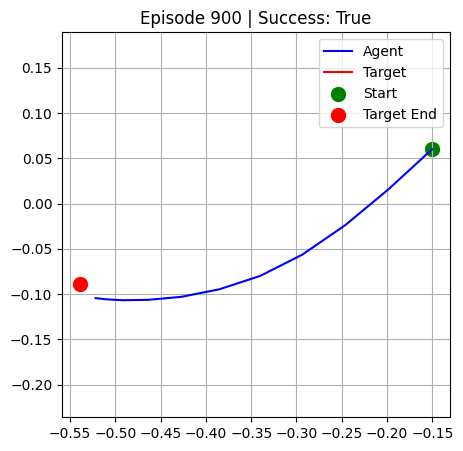

Episode 901 | Final distance: 0.0177 | Success: True
Episode 902 | Final distance: 0.0158 | Success: True
Episode 903 | Final distance: 0.0123 | Success: True
Episode 904 | Final distance: 0.0136 | Success: True
Episode 905 | Final distance: 0.0107 | Success: True
Episode 906 | Final distance: 0.0196 | Success: True
Episode 907 | Final distance: 0.0144 | Success: True
Episode 908 | Final distance: 0.0180 | Success: True
Episode 909 | Final distance: 0.0200 | Success: True
Episode 910 | Final distance: 0.0132 | Success: True
Episode 911 | Final distance: 0.0079 | Success: True
Episode 912 | Final distance: 0.0159 | Success: True
Episode 913 | Final distance: 0.0189 | Success: True
Episode 914 | Final distance: 0.0199 | Success: True
Episode 915 | Final distance: 0.0187 | Success: True
Episode 916 | Final distance: 0.0198 | Success: True
Episode 917 | Final distance: 0.0145 | Success: True
Episode 918 | Final distance: 0.0183 | Success: True
Episode 919 | Final distance: 0.0193 | Success

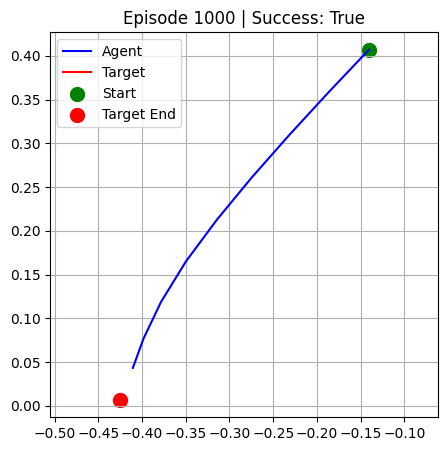

Success rate: 965/1001 | Avg final distance: 0.0154


In [11]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from environment import TrackingEnv
from ppo import PPOAgent, PolicyNet, ValueNet  # Cambia 'your_ppo_file' con il nome del file corretto


def load_ppo_agent(checkpoint_path, state_dim, action_dim):
    agent = PPOAgent(state_dim, action_dim)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    agent.actor.load_state_dict(checkpoint['actor_state_dict'])
    agent.critic.load_state_dict(checkpoint['critic_state_dict'])
    agent.eval()
    return agent


def test_ppo_agent(agent, env=None, num_episodes=1001, tolerance=0.02, save_dir="ppo_test_results"):
    if env is None:
        env = TrackingEnv()
    success_count = 0
    final_distances = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        trajectory = []
        target_trajectory = []

        while not done:
            trajectory.append(state[:2].detach().numpy())
            target_trajectory.append(state[2:4].detach().numpy())
            with torch.no_grad():
                mu, sigma = agent.actor(state)
                dist = torch.distributions.Normal(mu, sigma)
                action = dist.mean  # greedy action
            next_state, _, done, truncated, _, _ = env.step(action.numpy())
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True
            state = next_state

        final_distance = torch.norm(state[:2] - state[2:4]).item()
        final_distances.append(final_distance)
        success = final_distance < tolerance
        if success:
            success_count += 1

        print(f"Episode {ep} | Final distance: {final_distance:.4f} | Success: {success}")

        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(5, 5))
            plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agent", color='blue')
            plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], label="Target", color='red')
            plt.scatter(*trajectory[0], color='green', label='Start', s=100)
            plt.scatter(*target_trajectory[-1], color='red', label='Target End', s=100)
            plt.axis('equal')
            plt.title(f"Episode {ep} | Success: {success}")
            plt.legend()
            plt.grid()
            plt.show()

    env.close()
    print(f"Success rate: {success_count}/{num_episodes} | Avg final distance: {np.mean(final_distances):.4f}")


if __name__ == "__main__":
    checkpoint_path = "runs/ppo_run_20250412_153252/checkpoint_ep10000.pth"
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = load_ppo_agent(checkpoint_path, state_dim, action_dim)
    test_ppo_agent(agent)


[Episode 0] Final distance: 0.0184 | Success: True


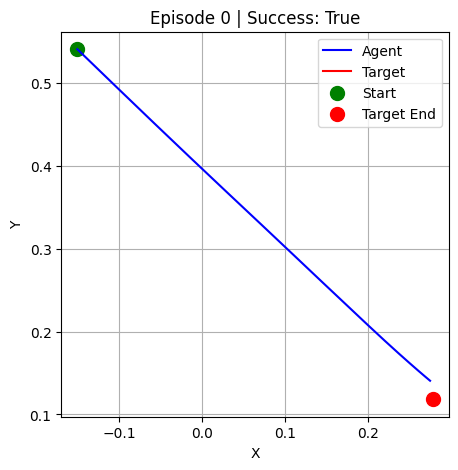

[Episode 1] Final distance: 0.0147 | Success: True
[Episode 2] Final distance: 0.0191 | Success: True
[Episode 3] Final distance: 0.0171 | Success: True
[Episode 4] Final distance: 0.0175 | Success: True
[Episode 5] Final distance: 0.0148 | Success: True
[Episode 6] Final distance: 0.0168 | Success: True
[Episode 7] Final distance: 0.0193 | Success: True
[Episode 8] Final distance: 0.0166 | Success: True
[Episode 9] Final distance: 0.0174 | Success: True
[Episode 10] Final distance: 0.0152 | Success: True
[Episode 11] Final distance: 0.0192 | Success: True
[Episode 12] Final distance: 0.0185 | Success: True
[Episode 13] Final distance: 0.0183 | Success: True
[Episode 14] Final distance: 0.0171 | Success: True
[Episode 15] Final distance: 0.0167 | Success: True
[Episode 16] Final distance: 0.0139 | Success: True
[Episode 17] Final distance: 0.0199 | Success: True
[Episode 18] Final distance: 0.0189 | Success: True
[Episode 19] Final distance: 0.0194 | Success: True
[Episode 20] Final di

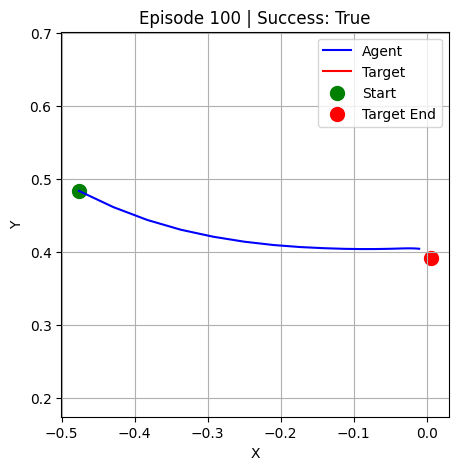

[Episode 101] Final distance: 0.0126 | Success: True
[Episode 102] Final distance: 0.0188 | Success: True
[Episode 103] Final distance: 0.0185 | Success: True
[Episode 104] Final distance: 0.0184 | Success: True
[Episode 105] Final distance: 0.0147 | Success: True
[Episode 106] Final distance: 0.0182 | Success: True
[Episode 107] Final distance: 0.0178 | Success: True
[Episode 108] Final distance: 0.0143 | Success: True
[Episode 109] Final distance: 0.0174 | Success: True
[Episode 110] Final distance: 0.0195 | Success: True
[Episode 111] Final distance: 0.0183 | Success: True
[Episode 112] Final distance: 0.0151 | Success: True
[Episode 113] Final distance: 0.0160 | Success: True
[Episode 114] Final distance: 0.0177 | Success: True
[Episode 115] Final distance: 0.0153 | Success: True
[Episode 116] Final distance: 0.0152 | Success: True
[Episode 117] Final distance: 0.0198 | Success: True
[Episode 118] Final distance: 0.0200 | Success: True
[Episode 119] Final distance: 0.0156 | Success

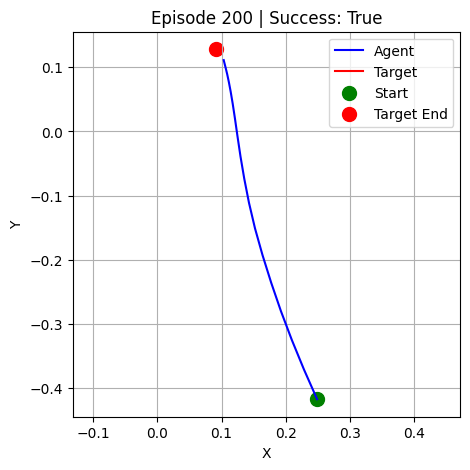

[Episode 201] Final distance: 0.0155 | Success: True
[Episode 202] Final distance: 0.0194 | Success: True
[Episode 203] Final distance: 0.0189 | Success: True
[Episode 204] Final distance: 0.0193 | Success: True
[Episode 205] Final distance: 0.0198 | Success: True
[Episode 206] Final distance: 0.0161 | Success: True
[Episode 207] Final distance: 0.0132 | Success: True
[Episode 208] Final distance: 0.0173 | Success: True
[Episode 209] Final distance: 0.0189 | Success: True
[Episode 210] Final distance: 0.0193 | Success: True
[Episode 211] Final distance: 0.0178 | Success: True
[Episode 212] Final distance: 0.0186 | Success: True
[Episode 213] Final distance: 0.0147 | Success: True
[Episode 214] Final distance: 0.0181 | Success: True
[Episode 215] Final distance: 0.0194 | Success: True
[Episode 216] Final distance: 0.0185 | Success: True
[Episode 217] Final distance: 0.0173 | Success: True
[Episode 218] Final distance: 0.0193 | Success: True
[Episode 219] Final distance: 0.0198 | Success

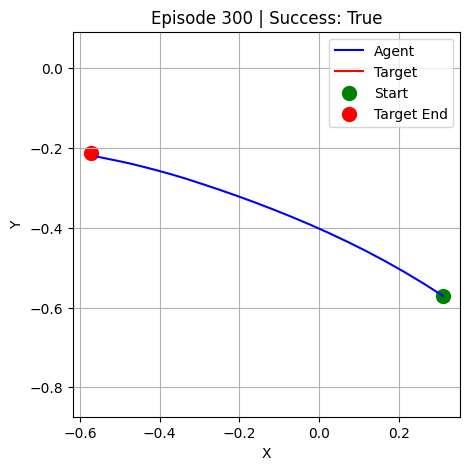

[Episode 301] Final distance: 0.0179 | Success: True
[Episode 302] Final distance: 0.0176 | Success: True
[Episode 303] Final distance: 0.0170 | Success: True
[Episode 304] Final distance: 0.0193 | Success: True
[Episode 305] Final distance: 0.0186 | Success: True
[Episode 306] Final distance: 0.0186 | Success: True
[Episode 307] Final distance: 0.0191 | Success: True
[Episode 308] Final distance: 0.0169 | Success: True
[Episode 309] Final distance: 0.0183 | Success: True
[Episode 310] Final distance: 0.0194 | Success: True
[Episode 311] Final distance: 0.0196 | Success: True
[Episode 312] Final distance: 0.0218 | Success: False
[Episode 313] Final distance: 0.0160 | Success: True
[Episode 314] Final distance: 0.0196 | Success: True
[Episode 315] Final distance: 0.0197 | Success: True
[Episode 316] Final distance: 0.0191 | Success: True
[Episode 317] Final distance: 0.0162 | Success: True
[Episode 318] Final distance: 0.0163 | Success: True
[Episode 319] Final distance: 0.0175 | Succes

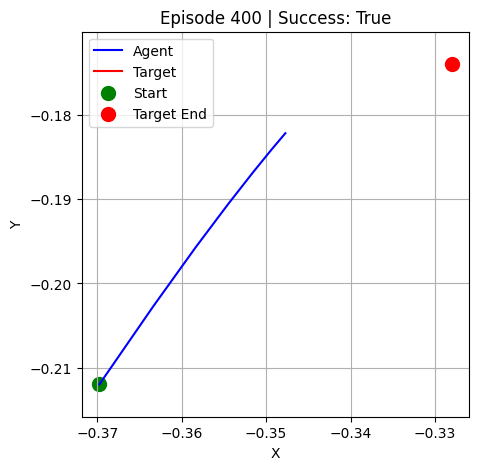

[Episode 401] Final distance: 0.0134 | Success: True
[Episode 402] Final distance: 0.0188 | Success: True
[Episode 403] Final distance: 0.0150 | Success: True
[Episode 404] Final distance: 0.0151 | Success: True
[Episode 405] Final distance: 0.0184 | Success: True
[Episode 406] Final distance: 0.0185 | Success: True
[Episode 407] Final distance: 0.0135 | Success: True
[Episode 408] Final distance: 0.0192 | Success: True
[Episode 409] Final distance: 0.0194 | Success: True
[Episode 410] Final distance: 0.0170 | Success: True
[Episode 411] Final distance: 0.0162 | Success: True
[Episode 412] Final distance: 0.0172 | Success: True
[Episode 413] Final distance: 0.0162 | Success: True
[Episode 414] Final distance: 0.0182 | Success: True
[Episode 415] Final distance: 0.0141 | Success: True
[Episode 416] Final distance: 0.0189 | Success: True
[Episode 417] Final distance: 0.0200 | Success: True
[Episode 418] Final distance: 0.0191 | Success: True
[Episode 419] Final distance: 0.0196 | Success

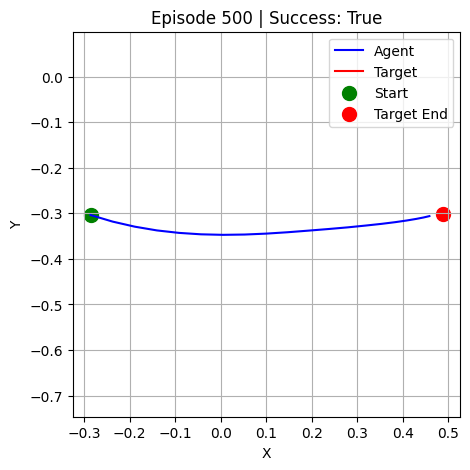

[Episode 501] Final distance: 0.0195 | Success: True
[Episode 502] Final distance: 0.0146 | Success: True
[Episode 503] Final distance: 0.0176 | Success: True
[Episode 504] Final distance: 0.0199 | Success: True
[Episode 505] Final distance: 0.0200 | Success: True
[Episode 506] Final distance: 0.0167 | Success: True
[Episode 507] Final distance: 0.0188 | Success: True
[Episode 508] Final distance: 0.0152 | Success: True
[Episode 509] Final distance: 0.0186 | Success: True
[Episode 510] Final distance: 0.0163 | Success: True
[Episode 511] Final distance: 0.0169 | Success: True
[Episode 512] Final distance: 0.0196 | Success: True
[Episode 513] Final distance: 0.0186 | Success: True
[Episode 514] Final distance: 0.0146 | Success: True
[Episode 515] Final distance: 0.0128 | Success: True
[Episode 516] Final distance: 0.0157 | Success: True
[Episode 517] Final distance: 0.0191 | Success: True
[Episode 518] Final distance: 0.0174 | Success: True
[Episode 519] Final distance: 0.0182 | Success

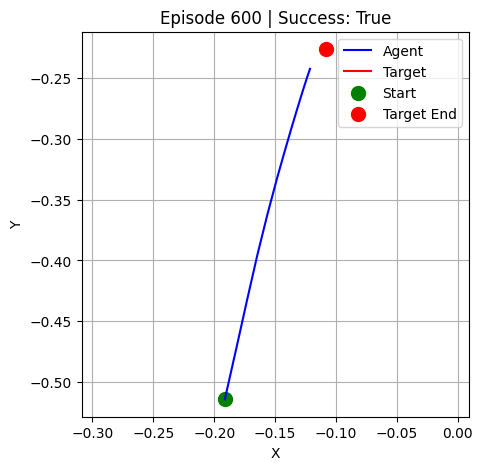

[Episode 601] Final distance: 0.0186 | Success: True
[Episode 602] Final distance: 0.0196 | Success: True
[Episode 603] Final distance: 0.0169 | Success: True
[Episode 604] Final distance: 0.0178 | Success: True
[Episode 605] Final distance: 0.0139 | Success: True
[Episode 606] Final distance: 0.0180 | Success: True
[Episode 607] Final distance: 0.0174 | Success: True
[Episode 608] Final distance: 0.0174 | Success: True
[Episode 609] Final distance: 0.0194 | Success: True
[Episode 610] Final distance: 0.0146 | Success: True
[Episode 611] Final distance: 0.0127 | Success: True
[Episode 612] Final distance: 0.0160 | Success: True
[Episode 613] Final distance: 0.0174 | Success: True
[Episode 614] Final distance: 0.0183 | Success: True
[Episode 615] Final distance: 0.0191 | Success: True
[Episode 616] Final distance: 0.0166 | Success: True
[Episode 617] Final distance: 0.0157 | Success: True
[Episode 618] Final distance: 0.0141 | Success: True
[Episode 619] Final distance: 0.0035 | Success

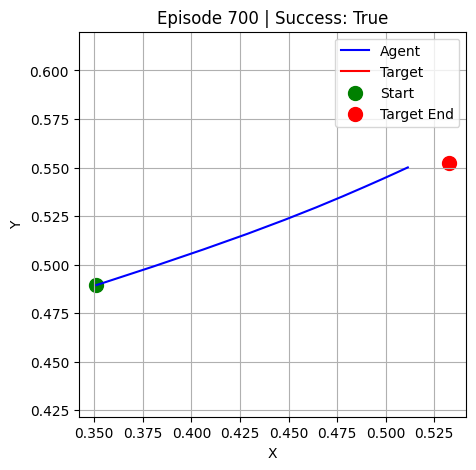

[Episode 701] Final distance: 0.0186 | Success: True
[Episode 702] Final distance: 0.0182 | Success: True
[Episode 703] Final distance: 0.0168 | Success: True
[Episode 704] Final distance: 0.0194 | Success: True
[Episode 705] Final distance: 0.0199 | Success: True
[Episode 706] Final distance: 0.0182 | Success: True
[Episode 707] Final distance: 0.0164 | Success: True
[Episode 708] Final distance: 0.0169 | Success: True
[Episode 709] Final distance: 0.0196 | Success: True
[Episode 710] Final distance: 0.0181 | Success: True
[Episode 711] Final distance: 0.0136 | Success: True
[Episode 712] Final distance: 0.0157 | Success: True
[Episode 713] Final distance: 0.0195 | Success: True
[Episode 714] Final distance: 0.0178 | Success: True
[Episode 715] Final distance: 0.0180 | Success: True
[Episode 716] Final distance: 0.0183 | Success: True
[Episode 717] Final distance: 0.0194 | Success: True
[Episode 718] Final distance: 0.0210 | Success: False
[Episode 719] Final distance: 0.0191 | Succes

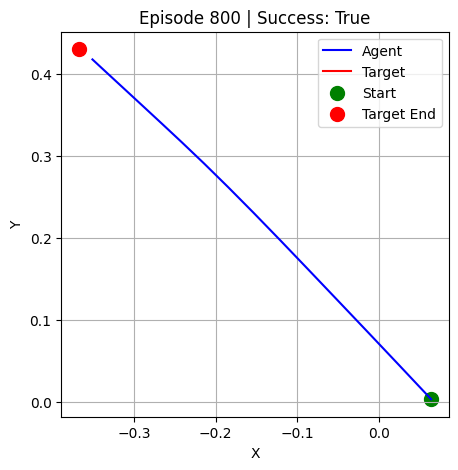

[Episode 801] Final distance: 0.0196 | Success: True
[Episode 802] Final distance: 0.0153 | Success: True
[Episode 803] Final distance: 0.0128 | Success: True
[Episode 804] Final distance: 0.0180 | Success: True
[Episode 805] Final distance: 0.0187 | Success: True
[Episode 806] Final distance: 0.0193 | Success: True
[Episode 807] Final distance: 0.0171 | Success: True
[Episode 808] Final distance: 0.0195 | Success: True
[Episode 809] Final distance: 0.0176 | Success: True
[Episode 810] Final distance: 0.0150 | Success: True
[Episode 811] Final distance: 0.0172 | Success: True
[Episode 812] Final distance: 0.0195 | Success: True
[Episode 813] Final distance: 0.0197 | Success: True
[Episode 814] Final distance: 0.0147 | Success: True
[Episode 815] Final distance: 0.0138 | Success: True
[Episode 816] Final distance: 0.0166 | Success: True
[Episode 817] Final distance: 0.0141 | Success: True
[Episode 818] Final distance: 0.0159 | Success: True
[Episode 819] Final distance: 0.0185 | Success

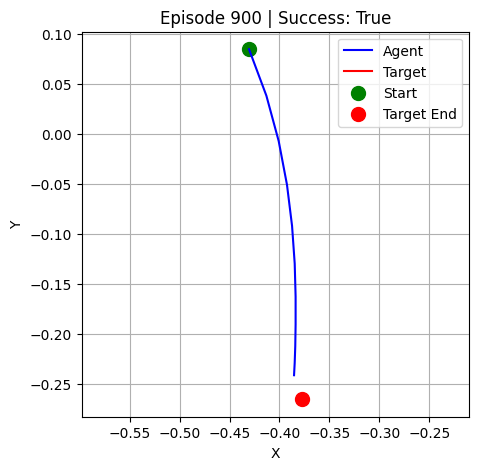

[Episode 901] Final distance: 0.0191 | Success: True
[Episode 902] Final distance: 0.0168 | Success: True
[Episode 903] Final distance: 0.0168 | Success: True
[Episode 904] Final distance: 0.0178 | Success: True
[Episode 905] Final distance: 0.0129 | Success: True
[Episode 906] Final distance: 0.0190 | Success: True
[Episode 907] Final distance: 0.0173 | Success: True
[Episode 908] Final distance: 0.0193 | Success: True
[Episode 909] Final distance: 0.0134 | Success: True
[Episode 910] Final distance: 0.0152 | Success: True
[Episode 911] Final distance: 0.0189 | Success: True
[Episode 912] Final distance: 0.0205 | Success: False
[Episode 913] Final distance: 0.0186 | Success: True
[Episode 914] Final distance: 0.0198 | Success: True
[Episode 915] Final distance: 0.0185 | Success: True
[Episode 916] Final distance: 0.0181 | Success: True
[Episode 917] Final distance: 0.0192 | Success: True
[Episode 918] Final distance: 0.0169 | Success: True
[Episode 919] Final distance: 0.0133 | Succes

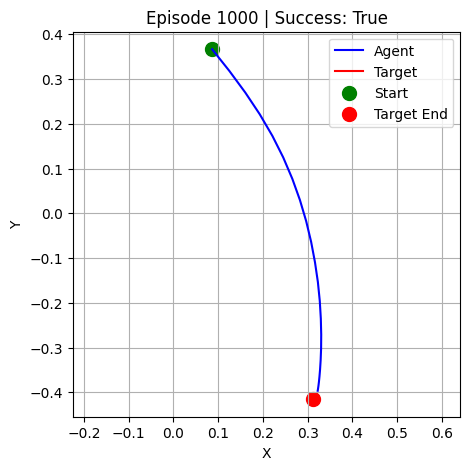


Success rate: 986/1001
Average final distance: 0.0173


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from environment import TrackingEnv
from ppo import PPOAgent, PolicyNet, ValueNet


def load_ppo_agent(checkpoint_path, state_dim, action_dim):
    agent = PPOAgent(state_dim, action_dim)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    agent.actor.load_state_dict(checkpoint['actor_state_dict'])
    agent.critic.load_state_dict(checkpoint['critic_state_dict'])
    agent.eval()
    return agent


def test_ppo_agent(agent, env=None, num_episodes=1001, tolerance=0.02, save_dir="ppo_test_results"):
    if env is None:
        env = TrackingEnv()

    success_count = 0
    final_distances = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        trajectory = []
        target_trajectory = []

        while not done:
            trajectory.append(state[:2].detach().numpy())
            target_trajectory.append(state[2:4].detach().numpy())
            with torch.no_grad():
                mu, sigma = agent.actor(state, training=False)  # No noise at test time
                action = mu  # Greedy action (no sampling)
            next_state, _, done, truncated, _, _ = env.step(action.numpy())
            next_state = torch.tensor(next_state, dtype=torch.float32)

            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True

            state = next_state

        final_distance = torch.norm(state[:2] - state[2:4]).item()
        final_distances.append(final_distance)
        success = final_distance < tolerance
        if success:
            success_count += 1

        print(f"[Episode {ep}] Final distance: {final_distance:.4f} | Success: {success}")

        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(5, 5))
            plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agent", color='blue')
            plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], label="Target", color='red')
            plt.scatter(*trajectory[0], color='green', label='Start', s=100)
            plt.scatter(*target_trajectory[-1], color='red', label='Target End', s=100)
            plt.title(f"Episode {ep} | Success: {success}")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.legend()
            plt.grid()
            plt.axis('equal')
            plt.show()

    env.close()
    print(f"\nSuccess rate: {success_count}/{num_episodes}")
    print(f"Average final distance: {np.mean(final_distances):.4f}")


if __name__ == "__main__":
    checkpoint_path = "runs/ppo_run_static_noise20250412_182030/checkpoint_ep10000.pth"
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = load_ppo_agent(checkpoint_path, state_dim, action_dim)
    test_ppo_agent(agent, env=env)


[Episode 0] Final distance: 0.0199 | Success: True


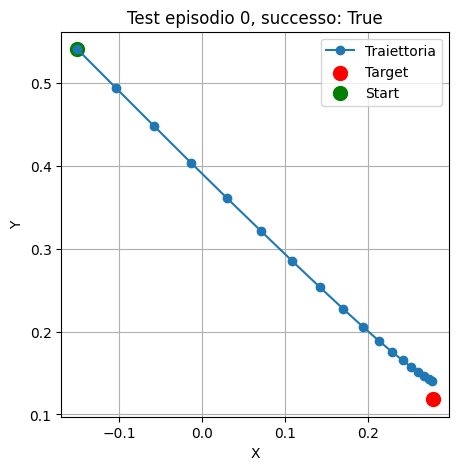

[Episode 1] Final distance: 0.0190 | Success: True
[Episode 2] Final distance: 0.0151 | Success: True
[Episode 3] Final distance: 0.0140 | Success: True
[Episode 4] Final distance: 0.0174 | Success: True
[Episode 5] Final distance: 0.0143 | Success: True
[Episode 6] Final distance: 0.0149 | Success: True
[Episode 7] Final distance: 0.0195 | Success: True
[Episode 8] Final distance: 0.0185 | Success: True
[Episode 9] Final distance: 0.0165 | Success: True
[Episode 10] Final distance: 0.0276 | Success: False
[Episode 11] Final distance: 0.0186 | Success: True
[Episode 12] Final distance: 0.0132 | Success: True
[Episode 13] Final distance: 0.0232 | Success: False
[Episode 14] Final distance: 0.0175 | Success: True
[Episode 15] Final distance: 0.0137 | Success: True
[Episode 16] Final distance: 0.0196 | Success: True
[Episode 17] Final distance: 0.0127 | Success: True
[Episode 18] Final distance: 0.0172 | Success: True
[Episode 19] Final distance: 0.0196 | Success: True
[Episode 20] Final 

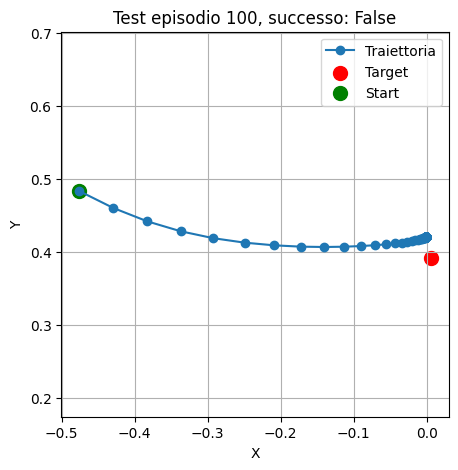

[Episode 101] Final distance: 0.0191 | Success: True
[Episode 102] Final distance: 0.0167 | Success: True
[Episode 103] Final distance: 0.0197 | Success: True
[Episode 104] Final distance: 0.0192 | Success: True
[Episode 105] Final distance: 0.0149 | Success: True
[Episode 106] Final distance: 0.0261 | Success: False
[Episode 107] Final distance: 0.0176 | Success: True
[Episode 108] Final distance: 0.0171 | Success: True
[Episode 109] Final distance: 0.0120 | Success: True
[Episode 110] Final distance: 0.0197 | Success: True
[Episode 111] Final distance: 0.0293 | Success: False
[Episode 112] Final distance: 0.0195 | Success: True
[Episode 113] Final distance: 0.0195 | Success: True
[Episode 114] Final distance: 0.0190 | Success: True
[Episode 115] Final distance: 0.0153 | Success: True
[Episode 116] Final distance: 0.0182 | Success: True
[Episode 117] Final distance: 0.0184 | Success: True
[Episode 118] Final distance: 0.0199 | Success: True
[Episode 119] Final distance: 0.0133 | Succe

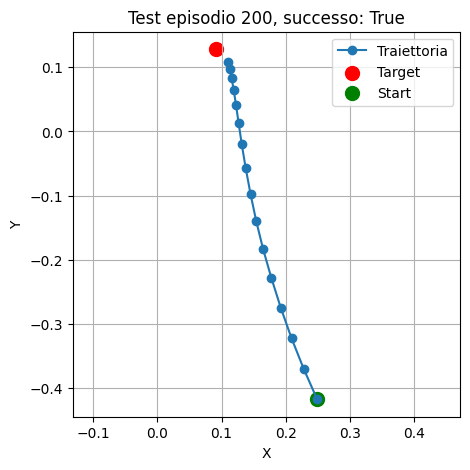

[Episode 201] Final distance: 0.0175 | Success: True
[Episode 202] Final distance: 0.0159 | Success: True
[Episode 203] Final distance: 0.0140 | Success: True
[Episode 204] Final distance: 0.0168 | Success: True
[Episode 205] Final distance: 0.0139 | Success: True
[Episode 206] Final distance: 0.0170 | Success: True
[Episode 207] Final distance: 0.0152 | Success: True
[Episode 208] Final distance: 0.0194 | Success: True
[Episode 209] Final distance: 0.0194 | Success: True
[Episode 210] Final distance: 0.0279 | Success: False
[Episode 211] Final distance: 0.0284 | Success: False
[Episode 212] Final distance: 0.0175 | Success: True
[Episode 213] Final distance: 0.0162 | Success: True
[Episode 214] Final distance: 0.0200 | Success: True
[Episode 215] Final distance: 0.0188 | Success: True
[Episode 216] Final distance: 0.0161 | Success: True
[Episode 217] Final distance: 0.0189 | Success: True
[Episode 218] Final distance: 0.0160 | Success: True
[Episode 219] Final distance: 0.0160 | Succe

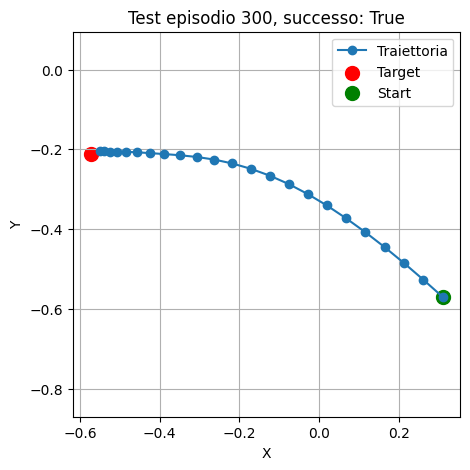

[Episode 301] Final distance: 0.0188 | Success: True
[Episode 302] Final distance: 0.0191 | Success: True
[Episode 303] Final distance: 0.0154 | Success: True
[Episode 304] Final distance: 0.0192 | Success: True
[Episode 305] Final distance: 0.0193 | Success: True
[Episode 306] Final distance: 0.0196 | Success: True
[Episode 307] Final distance: 0.0295 | Success: False
[Episode 308] Final distance: 0.0199 | Success: True
[Episode 309] Final distance: 0.0198 | Success: True
[Episode 310] Final distance: 0.0286 | Success: False
[Episode 311] Final distance: 0.0183 | Success: True
[Episode 312] Final distance: 0.0203 | Success: False
[Episode 313] Final distance: 0.0151 | Success: True
[Episode 314] Final distance: 0.0177 | Success: True
[Episode 315] Final distance: 0.0184 | Success: True
[Episode 316] Final distance: 0.0191 | Success: True
[Episode 317] Final distance: 0.0153 | Success: True
[Episode 318] Final distance: 0.0190 | Success: True
[Episode 319] Final distance: 0.0179 | Succ

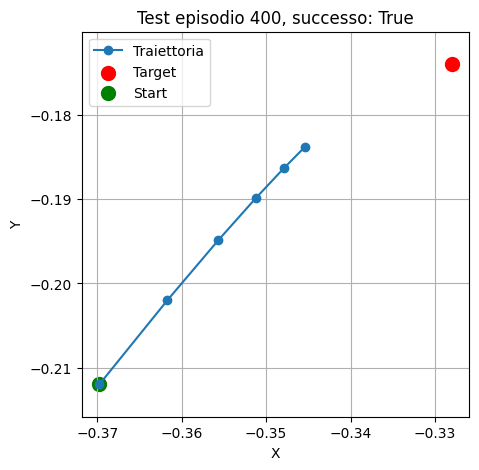

[Episode 401] Final distance: 0.0199 | Success: True
[Episode 402] Final distance: 0.0163 | Success: True
[Episode 403] Final distance: 0.0153 | Success: True
[Episode 404] Final distance: 0.0227 | Success: False
[Episode 405] Final distance: 0.0163 | Success: True
[Episode 406] Final distance: 0.0188 | Success: True
[Episode 407] Final distance: 0.0199 | Success: True
[Episode 408] Final distance: 0.0283 | Success: False
[Episode 409] Final distance: 0.0104 | Success: True
[Episode 410] Final distance: 0.0205 | Success: False
[Episode 411] Final distance: 0.0261 | Success: False
[Episode 412] Final distance: 0.0166 | Success: True
[Episode 413] Final distance: 0.0195 | Success: True
[Episode 414] Final distance: 0.0162 | Success: True
[Episode 415] Final distance: 0.0130 | Success: True
[Episode 416] Final distance: 0.0186 | Success: True
[Episode 417] Final distance: 0.0243 | Success: False
[Episode 418] Final distance: 0.0234 | Success: False
[Episode 419] Final distance: 0.0186 | S

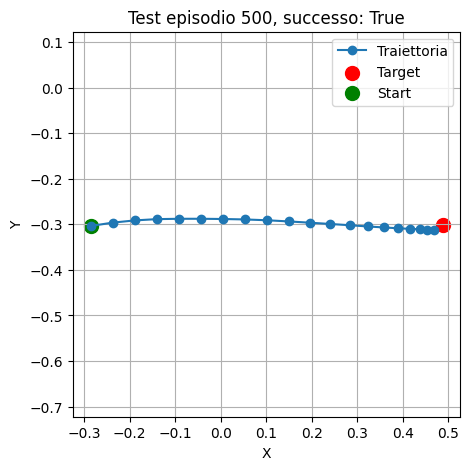

[Episode 501] Final distance: 0.0272 | Success: False
[Episode 502] Final distance: 0.0191 | Success: True
[Episode 503] Final distance: 0.0171 | Success: True
[Episode 504] Final distance: 0.0165 | Success: True
[Episode 505] Final distance: 0.0194 | Success: True
[Episode 506] Final distance: 0.0189 | Success: True
[Episode 507] Final distance: 0.0148 | Success: True
[Episode 508] Final distance: 0.0143 | Success: True
[Episode 509] Final distance: 0.0182 | Success: True
[Episode 510] Final distance: 0.0172 | Success: True
[Episode 511] Final distance: 0.0172 | Success: True
[Episode 512] Final distance: 0.0131 | Success: True
[Episode 513] Final distance: 0.0183 | Success: True
[Episode 514] Final distance: 0.0188 | Success: True
[Episode 515] Final distance: 0.0185 | Success: True
[Episode 516] Final distance: 0.0191 | Success: True
[Episode 517] Final distance: 0.0168 | Success: True
[Episode 518] Final distance: 0.0195 | Success: True
[Episode 519] Final distance: 0.0189 | Succes

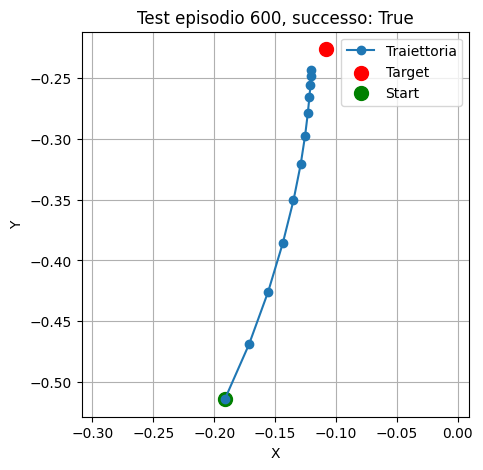

[Episode 601] Final distance: 0.0176 | Success: True
[Episode 602] Final distance: 0.0196 | Success: True
[Episode 603] Final distance: 0.0125 | Success: True
[Episode 604] Final distance: 0.0183 | Success: True
[Episode 605] Final distance: 0.0167 | Success: True
[Episode 606] Final distance: 0.0170 | Success: True
[Episode 607] Final distance: 0.0203 | Success: False
[Episode 608] Final distance: 0.0211 | Success: False
[Episode 609] Final distance: 0.0169 | Success: True
[Episode 610] Final distance: 0.0102 | Success: True
[Episode 611] Final distance: 0.0191 | Success: True
[Episode 612] Final distance: 0.0188 | Success: True
[Episode 613] Final distance: 0.0189 | Success: True
[Episode 614] Final distance: 0.0186 | Success: True
[Episode 615] Final distance: 0.0196 | Success: True
[Episode 616] Final distance: 0.0168 | Success: True
[Episode 617] Final distance: 0.0124 | Success: True
[Episode 618] Final distance: 0.0273 | Success: False
[Episode 619] Final distance: 0.0005 | Succ

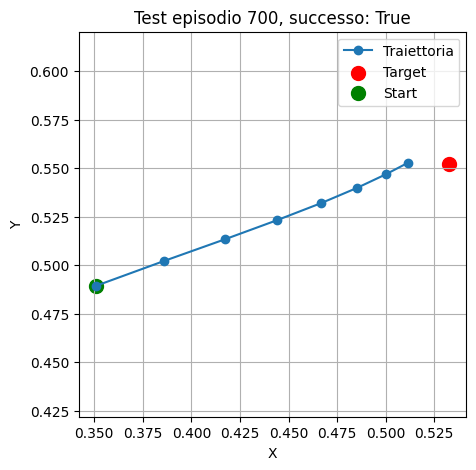

[Episode 701] Final distance: 0.0179 | Success: True
[Episode 702] Final distance: 0.0195 | Success: True
[Episode 703] Final distance: 0.0154 | Success: True
[Episode 704] Final distance: 0.0182 | Success: True
[Episode 705] Final distance: 0.0181 | Success: True
[Episode 706] Final distance: 0.0141 | Success: True
[Episode 707] Final distance: 0.0125 | Success: True
[Episode 708] Final distance: 0.0141 | Success: True
[Episode 709] Final distance: 0.0200 | Success: True
[Episode 710] Final distance: 0.0139 | Success: True
[Episode 711] Final distance: 0.0153 | Success: True
[Episode 712] Final distance: 0.0183 | Success: True
[Episode 713] Final distance: 0.0180 | Success: True
[Episode 714] Final distance: 0.0151 | Success: True
[Episode 715] Final distance: 0.0174 | Success: True
[Episode 716] Final distance: 0.0145 | Success: True
[Episode 717] Final distance: 0.0190 | Success: True
[Episode 718] Final distance: 0.0199 | Success: True
[Episode 719] Final distance: 0.0167 | Success

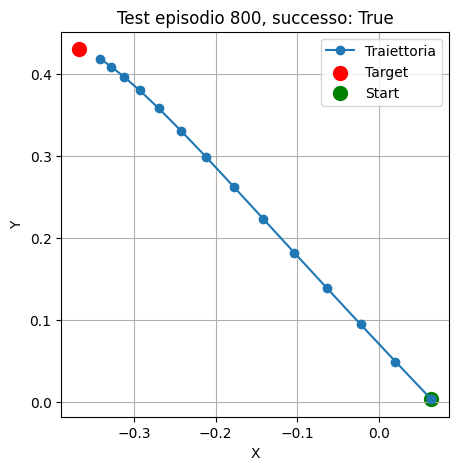

[Episode 801] Final distance: 0.0284 | Success: False
[Episode 802] Final distance: 0.0125 | Success: True
[Episode 803] Final distance: 0.0186 | Success: True
[Episode 804] Final distance: 0.0174 | Success: True
[Episode 805] Final distance: 0.0195 | Success: True
[Episode 806] Final distance: 0.0181 | Success: True
[Episode 807] Final distance: 0.0180 | Success: True
[Episode 808] Final distance: 0.0191 | Success: True
[Episode 809] Final distance: 0.0181 | Success: True
[Episode 810] Final distance: 0.0163 | Success: True
[Episode 811] Final distance: 0.0177 | Success: True
[Episode 812] Final distance: 0.0136 | Success: True
[Episode 813] Final distance: 0.0141 | Success: True
[Episode 814] Final distance: 0.0113 | Success: True
[Episode 815] Final distance: 0.0169 | Success: True
[Episode 816] Final distance: 0.0145 | Success: True
[Episode 817] Final distance: 0.0192 | Success: True
[Episode 818] Final distance: 0.0161 | Success: True
[Episode 819] Final distance: 0.0188 | Succes

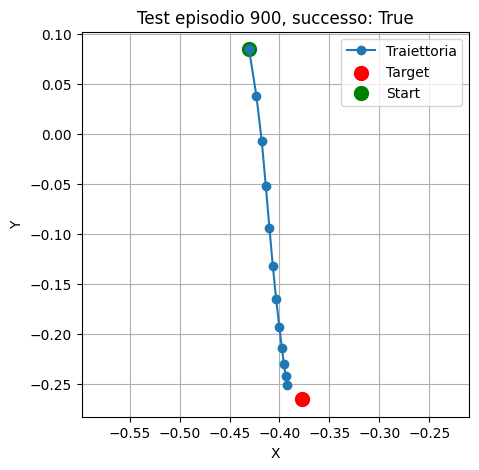

[Episode 901] Final distance: 0.0155 | Success: True
[Episode 902] Final distance: 0.0183 | Success: True
[Episode 903] Final distance: 0.0152 | Success: True
[Episode 904] Final distance: 0.0180 | Success: True
[Episode 905] Final distance: 0.0163 | Success: True
[Episode 906] Final distance: 0.0200 | Success: True
[Episode 907] Final distance: 0.0168 | Success: True
[Episode 908] Final distance: 0.0199 | Success: True
[Episode 909] Final distance: 0.0149 | Success: True
[Episode 910] Final distance: 0.0184 | Success: True
[Episode 911] Final distance: 0.0197 | Success: True
[Episode 912] Final distance: 0.0197 | Success: True
[Episode 913] Final distance: 0.0192 | Success: True
[Episode 914] Final distance: 0.0177 | Success: True
[Episode 915] Final distance: 0.0172 | Success: True
[Episode 916] Final distance: 0.0198 | Success: True
[Episode 917] Final distance: 0.0201 | Success: False
[Episode 918] Final distance: 0.0174 | Success: True
[Episode 919] Final distance: 0.0195 | Succes

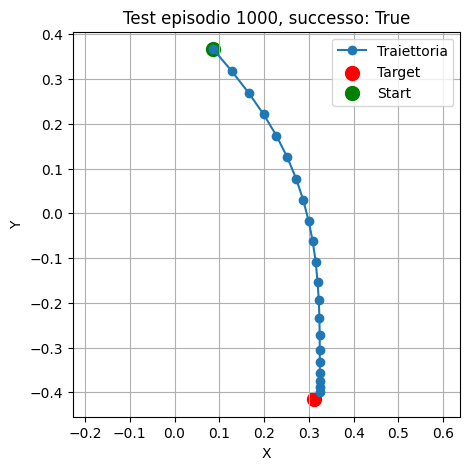


Success rate: 910/1001
Average final distance: 0.0177


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from environment import TrackingEnv
from ppo import PPOAgent, PolicyNet, ValueNet


def load_ppo_agent(checkpoint_path, state_dim, action_dim):
    agent = PPOAgent(state_dim, action_dim)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    agent.actor.load_state_dict(checkpoint['actor_state_dict'])
    agent.critic.load_state_dict(checkpoint['critic_state_dict'])
    agent.eval()
    return agent


def test_ppo_agent(agent, env=None, num_episodes=1001, tolerance=0.02):
    if env is None:
        env = TrackingEnv()

    success_count = 0
    final_distances = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        trajectory = []
        target_trajectory = []

        while not done:
            trajectory.append(state[:2].detach().numpy())
            target_trajectory.append(state[2:4].detach().numpy())
            with torch.no_grad():
                mu, sigma = agent.actor(state, training=False)  # No noise at test time
                action = mu  # Greedy action (no sampling)
            next_state, _, done, truncated, _, _ = env.step(action.numpy())
            next_state = torch.tensor(next_state, dtype=torch.float32)

            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True

            state = next_state

        final_distance = torch.norm(state[:2] - state[2:4]).item()
        final_distances.append(final_distance)
        success = final_distance < tolerance
        if success:
            success_count += 1

        print(f"[Episode {ep}] Final distance: {final_distance:.4f} | Success: {success}")

        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(5, 5))
            plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
            plt.scatter(*state[2:4], color='red', label='Target', s=100)
            plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
            plt.title(f"Test episodio {ep}, successo: {success}")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.legend()
            plt.grid()
            plt.axis('equal')
            plt.show()

    env.close()
    print(f"\nSuccess rate: {success_count}/{num_episodes}")
    print(f"Average final distance: {np.mean(final_distances):.4f}")


if __name__ == "__main__":
    checkpoint_path = "runs/ppo_run_noise_only_target20250413_125929/checkpoint_ep10000.pth"
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    agent = load_ppo_agent(checkpoint_path, state_dim, action_dim)
    test_ppo_agent(agent, env=env)
